In [1]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier, BaggingRegressor
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from mlxtend.plotting import plot_learning_curves
from yellowbrick.model_selection import LearningCurve
import matplotlib.gridspec as gridspec
import itertools
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import shuffle
plt.style.use('fivethirtyeight')

In [2]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        tmin, tsec = divmod((datetime.now() - start_time).total_seconds(), 60)
        print('\n Tempo Necessário: %i minutos and %s segundos.' % (tmin, round(tsec, 2)))

**Inserir os caminhos de Treino e Validação - Testar com a base de teste somente no final**  
**Ajustar a quantia de características no dataframe**  
**Ajustar o nome da variável alvo**

In [3]:
train = pd.read_csv('trainLR.csv')
train = shuffle(train)
X_train = train.iloc[:,1:87]
Y_train = train.loc[:, train.columns == 'Y']
test = pd.read_csv('testLR.csv')
test = shuffle(test)
X_test = test.iloc[:,1:87]
Y_test = test.loc[:, test.columns == 'Y']

In [4]:
print(X_train.shape)

(45063, 86)


In [5]:
print(X_test.shape)

(27038, 86)


In [6]:
Y_train.head()

,Y
32132,0
16177,0
26589,1
7828,1
35373,0


**Voting Ensemble**


 Tempo Necessário: 2 minutos and 27.12 segundos.
0.6234383806010829


<Figure size 432x288 with 0 Axes>

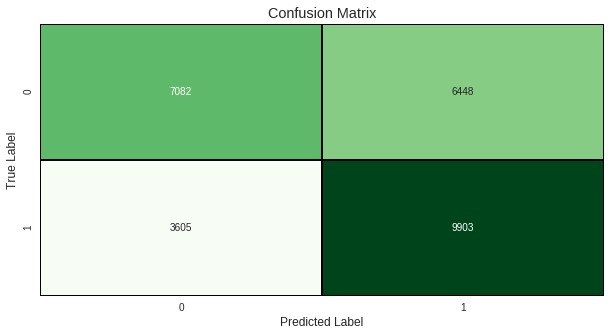

<Figure size 432x288 with 0 Axes>

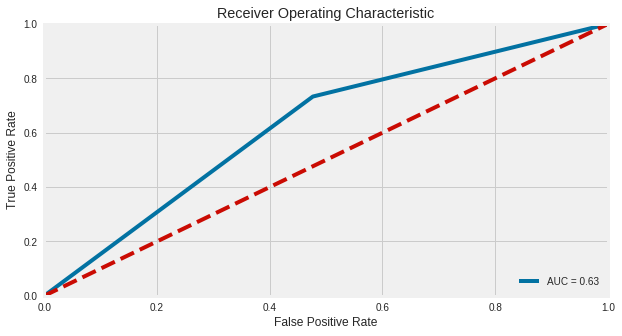

<Figure size 432x288 with 0 Axes>

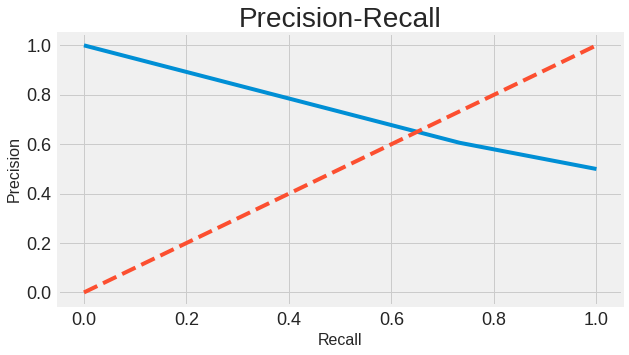

Classification Report
              precision    recall  f1-score   support

           0       0.66      0.52      0.58     13530
           1       0.61      0.73      0.66     13508

    accuracy                           0.63     27038
   macro avg       0.63      0.63      0.62     27038
weighted avg       0.63      0.63      0.62     27038

Acurácia do Modelo


0.6281899548783194

In [7]:
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import RobustScaler

std = RobustScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

starttime = timer(None)
start_time = timer(None)

#Best: 0.616492 using {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 300}
model1 = RandomForestClassifier(n_estimators=300, max_depth=8, criterion='gini', n_jobs=4)

#Best: 0.614828 using {'learning_rate': 0.4, 'n_estimators': 600}
model2 = AdaBoostClassifier(n_estimators=600, learning_rate=0.4)

#Best: 0.628343 using {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'objective': 'binary:logistic'}
model3 = XGBClassifier(learning_rate=0.2, max_depth=3, n_estimators=200, objective='binary:logistic', n_jobs=4)
    
    
model = VotingClassifier(estimators=[('rf', model1), ('ada', model2), ('xgb', model3)], voting='hard')

                                     
model.fit(X_train,Y_train.values.ravel())
model.score(X_test,Y_test.values.ravel())
predictions_model = model.predict(X_test)
scores = cross_val_score(model, X_train, Y_train.values.ravel(), cv=3)
timer(start_time)
print(scores.mean())

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, predictions_model)
roc_auc = auc(false_positive_rate, true_positive_rate)
matrix_model = confusion_matrix(Y_test, predictions_model)



plt.figure(1)
plt.figure(figsize=(9,5))
model_heatmap = sns.heatmap(matrix_model,annot=True, cbar=False, fmt="d", cmap ='Greens', linecolor ='black', linewidths = 1)
bottom, top = model_heatmap.get_ylim()
model_heatmap.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

plt.figure(2)
plt.figure(figsize=(9,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.0,1.0])
plt.ylim([-0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.figure(3)
precision, recall, thresholds = precision_recall_curve(Y_test, predictions_model)
plt.figure(figsize = (9,5))
plt.plot(recall, precision)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlabel('Recall', fontsize = 16)
plt.ylabel('Precision', fontsize = 16)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.title('Precision-Recall', fontsize = 28)
plt.show();


print("Classification Report")
print(classification_report(Y_test, predictions_model))

print("Acurácia do Modelo")
accuracy_score(Y_test, predictions_model)

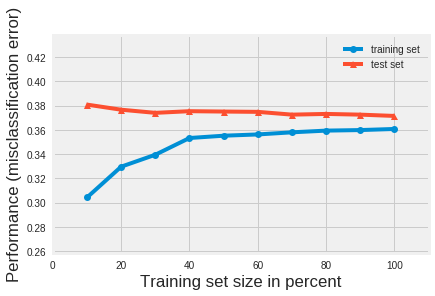

In [8]:
plt.figure()
plot_learning_curves(X_train, Y_train.values.ravel(), X_test, Y_test.values.ravel(), model, print_model=False)
plt.show()